In [1]:
import Zygote: @ignore_derivatives
import Optimisers
import Zygote
import Plots
import CSV
import Random
import GLM
using Lux
using DataFrames
using ComponentArrays
using PartialFunctions
using SciMLSensitivity
using DifferentialEquations
using JLD2
using Printf


include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/objectives.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/lux.helpers.jl");

basic_tgrad(u,p,t) = zero(u)

basic_tgrad (generic function with 1 method)

## Data preparation

In [5]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

In [6]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        𝐈 = Matrix{Float32}(group[group.mdv .== 1, [:t, :amt, :rate, :duration]])
        callback = generate_dosing_callback(𝐈)
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), callback; id = group.id[1])
    end
    return Population(indvs);
end
population = create_population(df_group);

## Training

### Functions

In [23]:
# Create neural network architecture.
function dnn(latent_dim)
    return Chain(
        Normalize([ones(latent_dim); 70; 40]),
        Dense(latent_dim + size(population.x, 1), 16, swish),
        Dense(16, 16, swish),
        Dense(16, 8, swish),
        Dense(8, latent_dim)
    )
end

# The function received by ODEFunction must have the form f(u, p, t; kwargs...).
# As the neural network receives [u; x] es inputs, we need to wrap the neural network on top of this function with the correct form.
# Additionally, we add the intervention as another parameter (will be used for the callbacks)
dudt(u, p, t; x, node, st) = node([u; x], p.weights, st)[1] + [p.I, 0.f0]

# Defines a method for the dudt function that accepts kwargs and calls the original dudt function with those arguments.
# The $ syntax (comes from PartialFunctions) is used to partially apply the function with the provided kwargs
dudt(; kwargs...) = dudt$(; kwargs...)

# Forward pass for one individual (solve the ODE)
function forward(model, individual::AbstractIndividual, p, st; dudt = dudt, get_dv::Bool=false, sensealg=nothing, full::Bool=false, interpolate::Bool=false, saveat_ = is_timevariable(individual) ? individual.t.y : individual.t)
    @ignore_derivatives p.I = zero(p.I)
    u0 = isempty(individual.initial) ? zeros(Float32, 2) : individual.initial
    saveat = interpolate ? empty(saveat_) : saveat_
    save_idxs = full ? (1:length(u0)) : 2
    
    f = dudt(; x = individual.x, node = model, st = st)
    ff = ODEFunction{false}(f; tgrad = basic_tgrad)
    prob = ODEProblem{false}(ff, u0, (-0.1f0, maximum(saveat_)), p)
    
    interpolate && (individual.callback.save_positions .= 1)
    sol = solve(prob, Tsit5(),
        save_idxs = save_idxs, saveat = saveat, callback=individual.callback, 
        tstops=individual.callback.condition.times, sensealg=sensealg
    )
    interpolate && (individual.callback.save_positions .= 0)
    return get_dv ? sol[2, :] : sol
end

# Forward pass for population. The Ref function "freezes" the parameters with respect to the dot operator
forward(model, population::Population, p, st; kwargs...) = forward.((model,), population, (p,), (st,); kwargs...)

# Function that will be called. Uses the default parameters
forward_adjoint(model, container, p, st) = forward(model, container, p, st; get_dv = true, full=true, sensealg=InterpolatingAdjoint(; autojacvec = ReverseDiffVJP()))

# Loss function (SSE)
function obj(node, population, p, st)
    ŷ = forward_adjoint(node, population, p, st)
    dif = reduce(vcat, population.y - ŷ)
    return sum(abs2, dif)/length(dif)
end

# Loss function (MAE)
function mae(node, population, p, st)
    ŷ = forward_adjoint(node, population, p, st)
    dif = reduce(vcat, population.y - ŷ)
    return sum(abs, dif)/length(dif)
end

# Train
function train_model(population_train, num_epochs, p; population_test=nothing, verbose=true, patience=100, tol=0.01)
    global opt_state
    losses = []
    losses_test = []
    times = []

    count = 0
    for epoch in 1:num_epochs

        elapsed_time = @elapsed begin
            loss, back = Zygote.pullback(p_ -> obj(node, population_train, ComponentVector((weights = p_.weights, I = 0.f0)), st), p)
            grad = first(back(1))
            opt_state, p = Optimisers.update(opt_state, p, grad)
        end
        push!(times, elapsed_time)

        push!(losses, loss)
        if population_test !== nothing
            push!(losses_test, obj(node, population_test, ComponentVector((weights = p.weights, I = 0.f0)), st))
        end

        if (epoch == 1 || epoch % 1 == 0)  && verbose
            println("Epoch $epoch, loss = $loss")
        end

        if epoch == 100      
            Optimisers.adjust!(opt_state, 0.001)
        end

        # Early stopping on percentual change of test loss. The test population is needed
        if population_test !== nothing
            if (epoch > 1) && ((losses_test[end-1] - losses_test[end])/losses_test[end-1] < tol)
                count += 1
                if count == patience
                    println("Early stopped. Percentual test loss did not improve at least $tol for $patience epochs. Trained for $epoch epochs\n")
                    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
                    return model, losses, losses_test
                end
            else 
                count = 0
            end
        end

    end
    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
    return p, losses, losses_test
end

# Plot predictions vs real values
function plot_predictions_real(node, p, st, population; threshold=0.2)
    real = reduce(vcat, population.y)
    preds = forward(node, population, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    plt = Plots.scatter(
        real,
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        legend=false
    )

    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))

    accuracy = count(x -> x < threshold, abs.((real - predicted)) ./ (real .+ 1e-6))/length(real)
    max_value = ceil(maximum(vcat(real, predicted)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        #ribbon = [0, max_value] .* threshold,
        fillalpha = 0.2,
        #color = "red",
        linestyle = :dash,
        
        )

    regression = GLM.predict(lr, DataFrame(X=[0, max_value]))
    rsquared = GLM.r2(lr)

    Plots.plot!(plt, 
        [0, max_value], 
        regression,
        color = "blue",
        title = "R2 = $(@sprintf("%.2f", rsquared))"
        )
    display(plt)
end

function training_metrics(node, p, st, population)
    #MAE
    mean_absolute_error = mae(node, population, ComponentVector((weights = p.weights, I = 0.f0)), st)

    #R2
    real = reduce(vcat, population.y)
    preds = forward(node, population, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)
    predicted = reduce(vcat, map(x -> x.u, preds))
    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))
    rsquared = GLM.r2(lr)

    return mean_absolute_error, rsquared
end


# Plot predictions vs real values
function plot_train_test_real(node, p, st, population_train, population_test)
    real = reduce(vcat, population_train.y)
    preds = forward(node, population_train, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    plt = Plots.scatter(
        real, 
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        label="Train"
    )

    real = reduce(vcat, population_test.y)
    preds = forward(node, population_test, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)
    predicted = reduce(vcat, map(x -> x.u, preds))

    Plots.scatter!(
        real, 
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:red,
        size=(600,400),
        label="Test"
    )

    max_value = ceil(maximum(reduce(vcat, population_train.y)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        linestyle = :dash,
        color=:black,
        label=nothing
        )
    display(plt)
end

plot_train_test_real (generic function with 2 methods)

### Train using all the population

In [38]:
latent_dim = 2

node = dnn(latent_dim)

ps, st = Lux.setup(Random.default_rng(), node)
p_ = ComponentVector((weights = ps, I = 0.f0));
p = (weights = ps,)

opt = Optimisers.Adam(0.01)
opt_state = Optimisers.setup(opt, p)

obj(node, population, p_, st)


871758.4f0

Epoch 1, loss = 871758.4
Epoch 2, loss = 589337.1
Epoch 3, loss = 341752.16
Epoch 4, loss = 164714.9
Epoch 5, loss = 28893.84
Epoch 6, loss = 9541.294
Epoch 7, loss = 1008.5837
Epoch 8, loss = 1011.6427
Epoch 9, loss = 1016.9053
Epoch 10, loss = 1060.6229
Epoch 11, loss = 30630.348
Epoch 12, loss = 1022.1498
Epoch 13, loss = 1025.1415
Epoch 14, loss = 1027.8789
Epoch 15, loss = 1030.3718
Epoch 16, loss = 1032.6437
Epoch 17, loss = 1034.7047
Epoch 18, loss = 1036.5743
Epoch 19, loss = 1038.262
Epoch 20, loss = 1039.7856
Epoch 21, loss = 1041.1532
Epoch 22, loss = 1042.3756
Epoch 23, loss = 1043.4636
Epoch 24, loss = 1044.4325
Epoch 25, loss = 1045.2856
Epoch 26, loss = 1046.03
Epoch 27, loss = 1046.6798
Epoch 28, loss = 1047.2386
Epoch 29, loss = 1047.7068
Epoch 30, loss = 1048.0787
Epoch 31, loss = 1048.1515
Epoch 32, loss = 1071.1693
Epoch 33, loss = 1048.2555
Epoch 34, loss = 1048.9609
Epoch 35, loss = 1049.0676
Epoch 36, loss = 1049.095
Epoch 37, loss = 1049.0831
Epoch 38, loss = 10

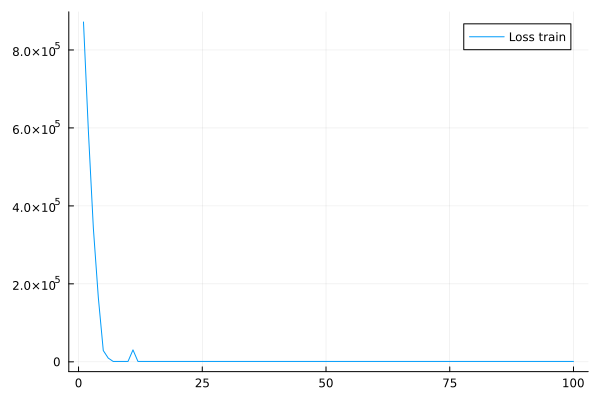

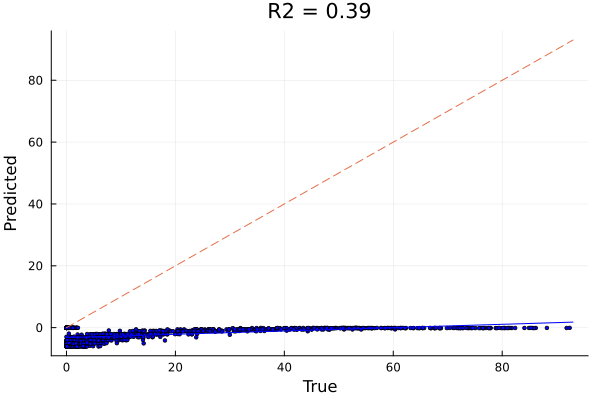

In [39]:
num_epochs = 200

p_final, losses, _ = train_model(population, num_epochs, p; population_test = nothing)

println()
final_mse = losses[end]
println("Final MSE: $final_mse")

final_mae, final_r2 = training_metrics(node, p_final, st, population)

println("Final MAE: $final_mae")
println("Final R2: $final_r2")

plt = Plots.plot(losses, label = "Loss train")
display(plt)

plot_predictions_real(node, p_final, st, population)

### Save/load model

In [167]:
# Save model
# jldsave("models/mymodel-fviii.jld2"; p_final, node, st)

In [54]:
# Load model
#mymodel = JLD2.load("models/mymodel-fviii.jld2")
#node = mymodel["node"]
#p_final = mymodel["p_final"]
#st = mymodel["st"]

(layer_1 = (lb = Float32[0.0, 0.0, 0.0, 0.0], ub = Float32[1.0, 1.0, 70.0, 40.0]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

### Train using test split

In [20]:
# Get random patients for train and test
Random.seed!(7)
ids = 1:length(df_group)
test_ids = sample(ids, div(length(ids), 4), replace = false)
train_ids = setdiff(ids, test_ids)

# Create train and test populations
population_test = create_population(df_group[test_ids]);
population_train = create_population(df_group[train_ids]);

latent_dim = 2
node = dnn(latent_dim)

ps, st = Lux.setup(Random.default_rng(), node)
p_ = ComponentVector((weights = ps, I = 0.f0));
p = (weights = ps,)

opt = Optimisers.Adam(0.01)
opt_state = Optimisers.setup(opt, p)

obj(node, population_train, p_, st)

114946.57f0

Epoch 1, loss = 114946.56
Epoch 2, loss = 23004.05
Epoch 3, loss = 9596.943
Epoch 4, loss = 20147.242
Epoch 5, loss = 16666.445
Epoch 6, loss = 10872.321
Epoch 7, loss = 6035.784
Epoch 8, loss = 2963.8916
Epoch 9, loss = 930.1203
Epoch 10, loss = 791.7586
Epoch 11, loss = 1740.8105
Epoch 12, loss = 2289.2522
Epoch 13, loss = 2402.401
Epoch 14, loss = 2153.1567
Epoch 15, loss = 1637.3558
Epoch 16, loss = 1088.6525
Epoch 17, loss = 662.9274
Epoch 18, loss = 435.49365
Epoch 19, loss = 407.2007
Epoch 20, loss = 508.33832
Epoch 21, loss = 595.8418
Epoch 22, loss = 621.1375
Epoch 23, loss = 598.91626
Epoch 24, loss = 544.6934
Epoch 25, loss = 472.77924
Epoch 26, loss = 397.092
Epoch 27, loss = 331.82355
Epoch 28, loss = 287.2549
Epoch 29, loss = 265.345
Epoch 30, loss = 261.87933
Epoch 31, loss = 269.9059
Epoch 32, loss = 282.3391
Epoch 33, loss = 292.56406
Epoch 34, loss = 296.21887
Epoch 35, loss = 292.21277
Epoch 36, loss = 281.0732
Epoch 37, loss = 265.66495
Epoch 38, loss = 249.17596
Ep

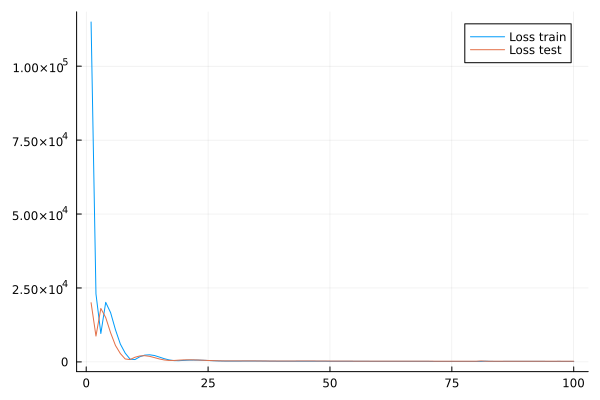


Final MAE train: 7.504548
Final R2 train: 0.7080625251516075

Final MAE test: 9.131186
Final R2 test: 0.6251486312414437


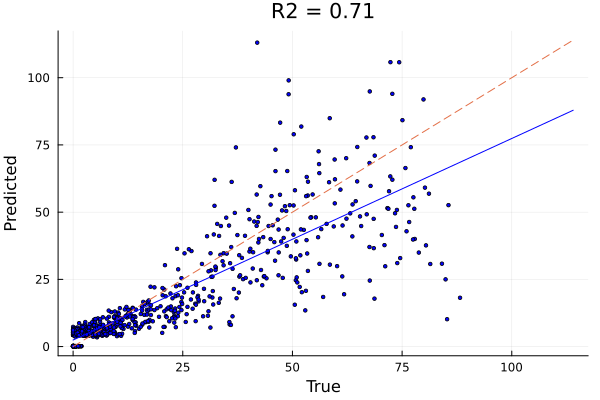

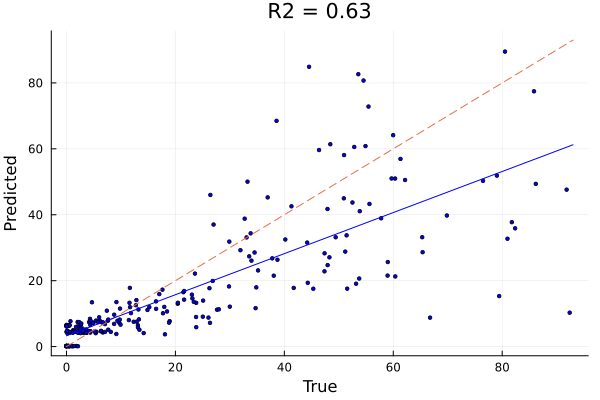

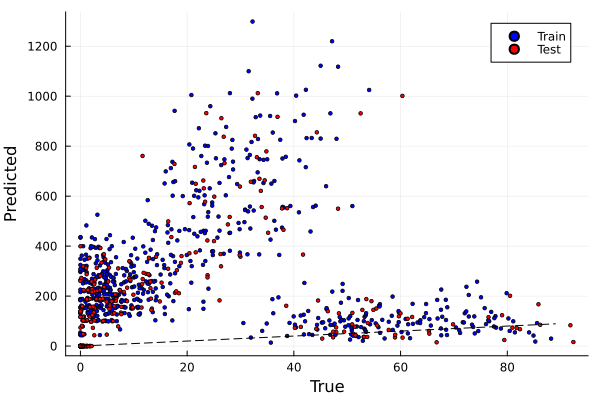

In [21]:

p_final, losses, losses_test = train_model(population_train, 100, p; population_test = population_test)

println()
plt = Plots.plot(losses, label = "Loss train")
Plots.plot!(plt, losses_test, label = "Loss test")
display(plt)

println()
final_mae_train, final_r2_train = training_metrics(node, p_final, st, population_train)
println("Final MAE train: $final_mae_train")
println("Final R2 train: $final_r2_train")
println()
final_mae_test, final_r2_test = training_metrics(node, p_final, st, population_test)
println("Final MAE test: $final_mae_test")
println("Final R2 test: $final_r2_test")

plot_predictions_real(node, p_final, st, population_train)
plot_predictions_real(node, p_final, st, population_test)

Final MAE train: 6.9724417
Final R2 train: 0.7360870086935398

Final MAE test: 8.528689
Final R2 test: 0.6479482920654112


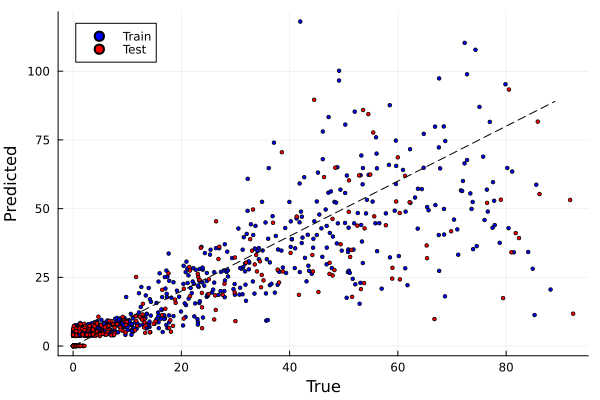

In [31]:
final_mae_train, final_r2_train = training_metrics(node, p_final, st, population_train)
println("Final MAE train: $final_mae_train")
println("Final R2 train: $final_r2_train")
println()
final_mae_test, final_r2_test = training_metrics(node, p_final, st, population_test)
println("Final MAE test: $final_mae_test")
println("Final R2 test: $final_r2_test")

plot_train_test_real(node, p_final, st, population_train, population_test)

In [61]:
12/2.2e-2

545.4545454545455

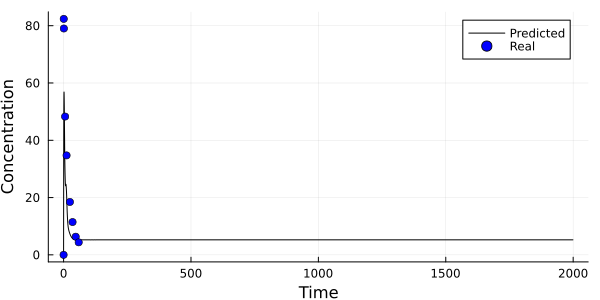

In [57]:
predict_real_individual(population[10], p_final; max_time = 2000, plot_predictions = true, plot_true_labels = true);

#Plots.savefig("./results/overfit.png");

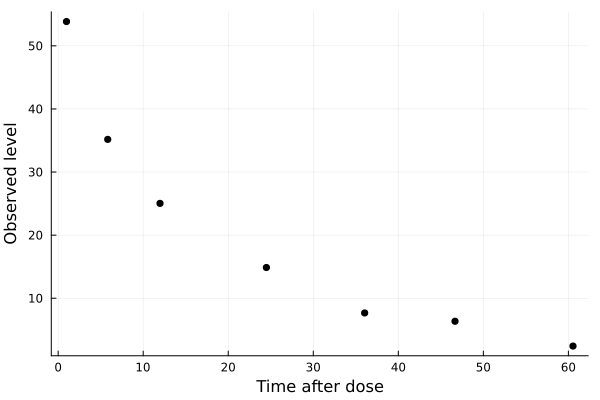

In [52]:
Plots.scatter(population[1].t[3:end], population[1].y[3:end], 
    label = nothing, xlabel="Time after dose", ylabel="Observed level",
    color = :black)

### K folds training

In [ ]:
# Get random patients for train and test
# folds = 7
# ids = 1:length(df_group)
# 
# l_mae_train = []
# l_mae_test = []
# l_r2_train = []
# l_r2_test = []
# 
# for i in 1:folds
#     println("Fold $i/$folds")
#     test_ids = sample(ids, div(length(ids), 4), replace = false)
#     train_ids = setdiff(ids, test_ids)
# 
#     # Create train and test populations
#     population_test = create_population(df_group[test_ids]);
#     population_train = create_population(df_group[train_ids]);
# 
#     latent_dim = 2
#     node = dnn(latent_dim)
#     
#     ps, st = Lux.setup(Random.default_rng(), node)
#     p_ = ComponentVector((weights = ps, I = 0.f0));
#     p = (weights = ps,)
#     
#     opt = Optimisers.Adam(0.01)
#     opt_state = Optimisers.setup(opt, p)
#     
#     p_final, _, _ = train_model(population_train, 300, p; population_test = population_test, verbose=false, patience=30, tol=0.001)
# 
#     final_mae_train, final_r2_train = training_metrics(node, p_final, st, population_train)
#     push!(l_mae_train, final_mae_train)
#     push!(l_r2_train, final_r2_train)
# 
#     final_mae_test, final_r2_test = training_metrics(node, p_final, st, population_test)
#     push!(l_mae_test, final_mae_test)
#     push!(l_r2_test, final_r2_test)
# end
# 
# # Remove largest and smallest values from list. To remove extreme cases that can happen due to initialization
# l_mae_train = filter(x -> x != maximum(l_mae_train) && x != minimum(l_mae_train), l_mae_train)
# l_mae_test = filter(x -> x != maximum(l_mae_test) && x != minimum(l_mae_test), l_mae_test)
# l_r2_train = filter(x -> x != maximum(l_r2_train) && x != minimum(l_r2_train), l_r2_train)
# l_r2_test = filter(x -> x != maximum(l_r2_test) && x != minimum(l_r2_test), l_r2_test)
# 
# println()
# println("Mean ± std MAE train: $(@sprintf("%.2f", mean(l_mae_train))) ± $(@sprintf("%.2f", std(l_mae_train)))")
# println("Mean ± std MAE test: $(@sprintf("%.2f", mean(l_mae_test))) ± $(@sprintf("%.2f", std(l_mae_test)))")
# println()
# println("Mean ± std R2 train: $(@sprintf("%.2f", mean(l_r2_train))) ± $(@sprintf("%.2f", std(l_r2_train)))")
# println("Mean ± std R2 test: $(@sprintf("%.2f", mean(l_r2_test))) ± $(@sprintf("%.2f", std(l_r2_test)))")

## Predict

### Functions

In [26]:
# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual, p; plot_predictions=false)

    predicted = forward(node, individual, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)

    if plot_predictions
        plt = Plots.plot(predicted.t, predicted.u, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end
    return predicted
end


# Predict a single real individual with labels. The predicted values are saved for all the times between 0 and max_time but the real labels are plotted for the real times
function predict_real_individual(individual, p; max_time = 120, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:0.1:(max_time-1))
    subject = Individual(individual.x, Float32.(time), Float32.(zeros(length(time))), individual.callback)

    predicted = forward(node, subject, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false)

    if plot_predictions
        plt = Plots.plot(predicted.t, predicted.u, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            Plots.scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end

# Create Intervention Matrix from [(time1, dose1), (time2, dose2), ...] list
function create_intervention_matrix(dose_list; duration = 120)
    if length(dose_list) == 0 return end
    M = []
    for (t, d) in dose_list
        row = [t, d, d * duration, 1/duration]
        push!(M, row)
    end

    # Convert the array of arrays to a matrix
    M = hcat(M...)
    M = M'
end

create_intervention_matrix (generic function with 1 method)

### Predict real individual from population with real labels

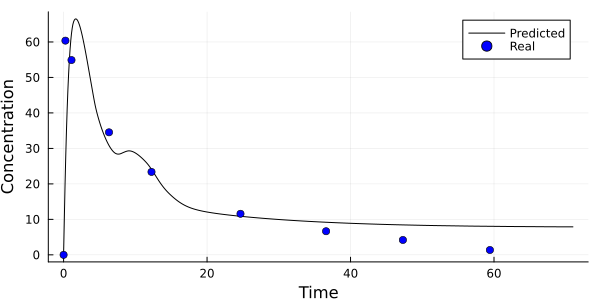

In [166]:
predict_real_individual(population[2], p_final; max_time = 72, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/fit_large_values.png");

# predict_real_individual(population[8], p_final; max_time = 120, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/discontinuity.png");


### Predict single individual without labels

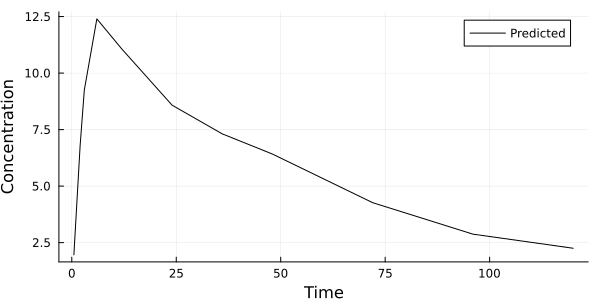

In [18]:
t = collect(0:1:200)
x = [70.0, 40.0, 1]

#doses = [(0,100), (80, 100)] # (Time, Dose)
doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), callback)
subject = population[2]

predict_individual(subject, p_final; plot_predictions=true);

## Experiments

### Functions

In [19]:
function test_variables(ind, p; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
    colors = Plots.palette(:rainbow, length(values))

    cback = ind.callback
    x = copy(ind.x)
    t = copy(ind.t)

    plt = Plots.plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        if variable == "AMT"
            I = create_intervention_matrix([(0.0, val)])
            cback = generate_dosing_callback(I)
        elseif variable == "WEIGHT"
            x[1] = val
        elseif variable == "AGE"
            x[2] = val
        elseif variable == "SEX"
            x[3] = val
        else
            error("Variable not found")
        end

        test_ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), cback)

        predicted = predict_individual(test_ind, p; plot_predictions=false);
        Plots.plot!(predicted.t, predicted.u, linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)
end

test_variables (generic function with 1 method)

### Initialize individual

In [20]:
t = collect(0:1:120)
x = [70.0, 40.0, 0]

doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), callback);

### Change AMT

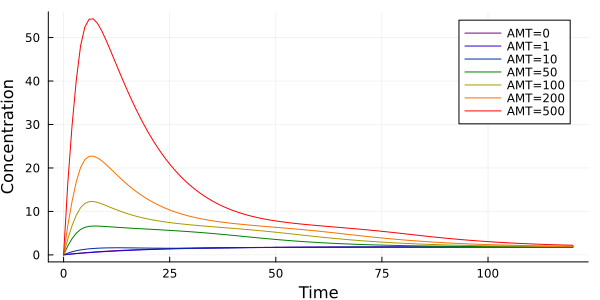

In [21]:
test_variables(subject, p_final; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
# Plots.savefig("./results/amt.png")

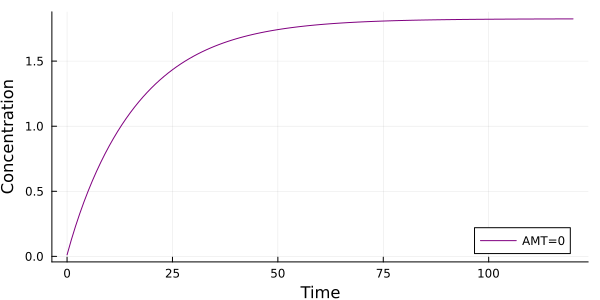

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/NeuralODE/results/amt0.png"

In [89]:
test_variables(subject, p_final; variable="AMT", values=[0])
# Plots.savefig("./results/amt0.png")

### Change Weight

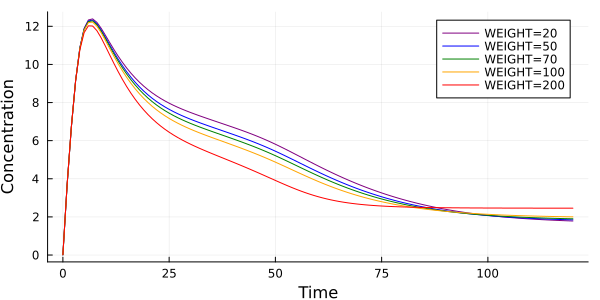

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/NeuralODE/results/weight.png"

In [90]:
test_variables(subject, p_final; variable="WEIGHT", values=[20, 50, 70, 100, 200])
#Plots.savefig("./results/weight.png")

### Change Age

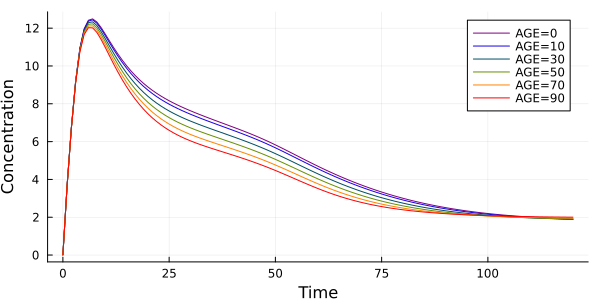

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/NeuralODE/results/age.png"

In [91]:
test_variables(subject, p_final; variable="AGE", values=[0, 10, 30, 50, 70, 90])
#Plots.savefig("./results/age.png")

### Change Sex

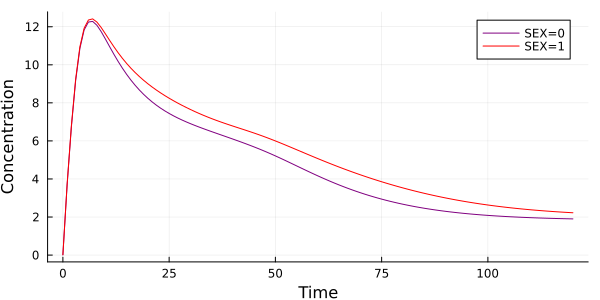

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/NeuralODE/results/sex.png"

In [92]:
test_variables(subject, p_final; variable="SEX", values=[0, 1])
#Plots.savefig("./results/sex.png")

### Simulate long time

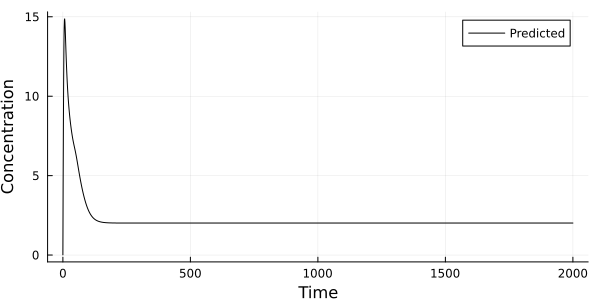

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/NeuralODE/results/long_time.png"

In [96]:
t = collect(0:1:2000)
x = [70.0, 40.0, 0]

doses = [(0,100)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)


subject = population[10];
x = copy(subject.x)
subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), subject.callback);
predict_individual(subject, p_final; plot_predictions=true);
# Plots.savefig("./results/long_time.png")